## Import libraries

In [1]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch
%matplotlib widget


In [2]:
plt.close("all")  # close all figure windows

## Initialization

### File selection and loading (REARM data)

In [3]:
# Define the xdf file path
FILENAME = "001_MolLud_20201112_1_c_499.txt"
# FILENAME="020_DesMar_20211129_1_c.xdf"
# path=os.path.normpath("../DAT/Input/001_MolLud_20201112_1_c.xdf")
path = os.path.normpath("DAT/INPUT/"+FILENAME)

In [4]:
EEG= np.loadtxt(path,dtype=float,delimiter=",")
EEG_raw_amplitudes=EEG[:,0:8]
EEG_times=EEG[:,8]
Srate=499
N=len(EEG_raw_amplitudes)

In [5]:
# definition of the EEG channels' names
channels_dic = {"Channel_1": "C4",
                "Channel_2": "FC2",
                "Channel_3": "FC6",
                "Channel_4": "CP2",
                "Channel_5": "C3",
                "Channel_6": "FC1",
                "Channel_7": "FC5",
                "Channel_8": "CP1"}

## Electrode selection

In [6]:
#Electrode selection [1;8]
i = 1  # electrode number
electrodei = EEG_raw_amplitudes[:, i-1]
print("electrode",str(i),"shape:",electrodei.shape)

electrode 1 shape: (221938,)


## Plots

### Raw signal

(221938, 8)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)


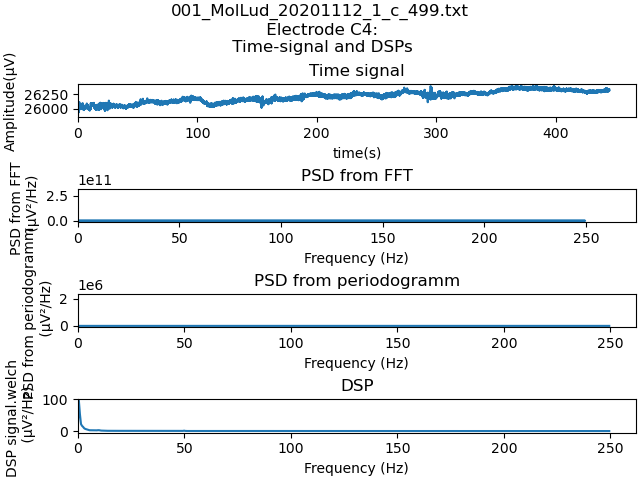

In [7]:
print(EEG_raw_amplitudes.shape)
plot_signal_time_dsps(EEG_raw_amplitudes[:,i],sample_rate=Srate,signal_name=FILENAME+"\n Electrode "+channels_dic["Channel_"+str(i)])

### Signal centering `python str(i)`


In [8]:
EEG_amplitudes_centered=EEG_raw_amplitudes-np.mean(EEG_raw_amplitudes,axis=0)

(221938, 8)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)


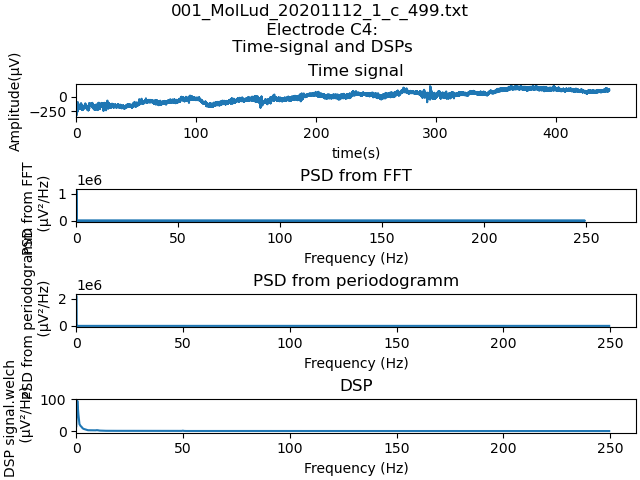

In [9]:
print(EEG_amplitudes_centered.shape)
plot_signal_time_dsps(EEG_amplitudes_centered[:,1],sample_rate=Srate,signal_name=FILENAME+"\n Electrode "+channels_dic["Channel_"+str(i)])

## Elecrode C3 

In [10]:
#Electrode selection [1;8]
i = 5  # electrode number
electrodei = EEG_raw_amplitudes[:, i-1]
print("electrode",str(i),"shape:",electrodei.shape)

electrode 5 shape: (221938,)


(221938, 8)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)


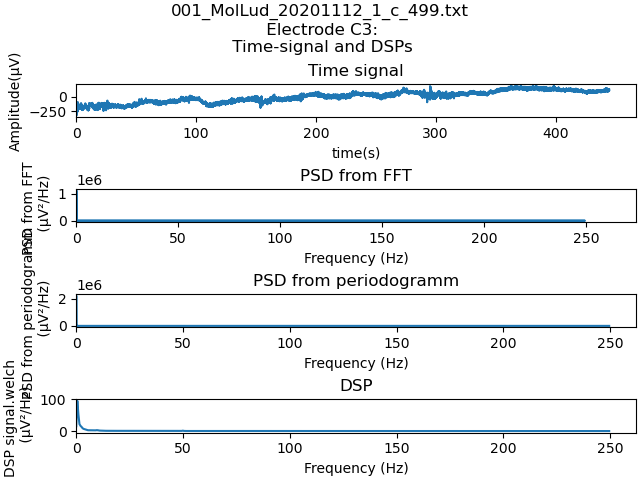

In [11]:
print(EEG_amplitudes_centered.shape)
plot_signal_time_dsps(EEG_amplitudes_centered[:,1],sample_rate=Srate,signal_name=FILENAME+"\n Electrode "+channels_dic["Channel_"+str(i)])